In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')

import pickle

import os
if not os.path.exists('./output'):
    os.makedirs('./output')

import sys

sys.path.append("..")
import lib

sys.path.append("../scripts/")
import th1



import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# data
checkpoint_dir = '../scripts/checkpoint/'
session_id = '12-120806'
phase = 'wake'

single_spikes = False
bin_size = 500

dataset_tuple = HDC.get_dataset(session_id, phase)
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple
#region_edge = metainfo[0]

# model
ll_mode = 'IPPexp'
filt_mode = ''
map_mode = 'svgp32'
x_mode = 'hd-isi1'
z_mode = ''
hist_len = 0
folds = 5
delays = [0]
m = (ll_mode, filt_mode, map_mode, x_mode, z_mode, hist_len, folds, delays)

# load
cv_run = 0
delay = 0
batch_size = 5000


modelfit, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, m, dataset_tuple, HDC.inputs_used, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5, J=100
)

NotImplementedError: Kernel type is not supported.

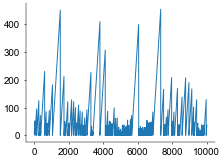

In [8]:
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple

plt.plot(rcov[-5][2, :10000, 0])

In [40]:
steps = 1000
covariates = [torch.linspace(0, 2*np.pi, steps)*0, torch.linspace(0, 1000.0, steps)]

use_neuron = [0, 1, 2]
trials = 1

cov = modelfit.mapping.to_XZ(covariates, trials)
with torch.no_grad():
    F_mu, F_var = modelfit.mapping.compute_F(cov)


with torch.no_grad():
    modelfit.mapping.jitter = 1e-4
    mc = 10
    eps = torch.randn(mc, 21, 1000, device=modelfit.mapping.dummy.device)
    F = modelfit.mapping.sample_F(cov, eps)

In [41]:
x = torch.exp(F)
p = x*torch.exp(-torch.cumsum(x, dim=-1)*0.001)

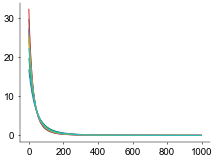

In [53]:
plt.plot(p[:, 15, :].cpu().numpy().T)
plt.show()

In [24]:
checkpoint_dir = '../scripts/checkpoint/'
session_id = '12-120806'
phase = 'wake'

dt = 0.001

ll_modes = ['IPPexp']#, 'IGexp', 'IIGexp', 'LNexp']
filt_mode = ''
map_mode = 'svgp32'
x_mode = 'hd-isi1'
z_mode = ''
hist_len = 0
folds = 5
delays = [0]



cv_meta = [(k, 0) for k in range(folds)]

### CV ###
batch_size = 5000
LL_arr = []
for ll_mode in ll_modes:
    m = (ll_mode, filt_mode, map_mode, x_mode, z_mode, hist_len, folds, delays)
    
    for cv_run, delay in cv_meta:
        # data
        dataset_tuple = HDC.get_dataset(session_id, phase)
        rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple
        #region_edge = metainfo[0]
        
        modelfit, fit_set, validation_set = lib.models.load_model(
            checkpoint_dir, m, dataset_tuple, HDC.inputs_used, HDC.enc_used, 
            delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5, J=100
        )
        
        # LL
        LL_arr.append(
            lib.helper.RG_pred_ll(
                modelfit, fit_set, batch_size, neuron_group=None, ll_mode='MC', 
                ll_samples=10, cov_samples=1, beta=0.0, bound='ELBO'
            )
        )
        
        if cv_run < 0:
            LL_arr.append(0.)
        else:
            LL_arr.append(
                lib.helper.RG_pred_ll(
                    modelfit, validation_set, batch_size, neuron_group=None, ll_mode='MC', 
                    ll_samples=10, cov_samples=1, beta=0.0, bound='ELBO'
                )
            )

LL_arr_cv_PP = np.array(LL_arr).reshape(len(ll_modes), len(cv_meta), 2)#, units_used)

Data set time steps: 1738680
Data set time steps: 434670
Data set time steps: 1738680
Data set time steps: 434670
Data set time steps: 1738680
Data set time steps: 434670
Data set time steps: 1738680
Data set time steps: 434670
Data set time steps: 1738680
Data set time steps: 434670


In [9]:
resamples

2173352

In [23]:
LL_arr_cv_PP

array([[[828438.230132  , 224211.0933908 ],
        [844886.55733657, 207856.85394217],
        [845999.07664332, 216269.45456178],
        [863015.20644756, 207445.93256106],
        [845015.51414332, 199756.12877155]]])

In [126]:
show_neuron = np.arange(units_used)
tau = []

for hd in np.linspace(0, 2*np.pi, 50):


    steps = 10000
    covariates = [hd*np.ones(steps)]*units_used + \
                 [np.arange(1,steps+1)*tbin]*units_used
    rho = glm.rate_model[0].eval_rate(covariates, show_neuron, 'mean')
    m = rho*tbin


    renew_dens = np.empty(m.shape)
    m_hist = 1
    for s in range(steps):
        renew_dens[:, s] = m[:, s]*m_hist
        m_hist *= (1-m[:, s])
        
    tau_ = (renew_dens*np.arange(1,steps+1)[None, :]*tbin).sum(-1)
    tau.append(tau_)
    
tau = np.array(tau)

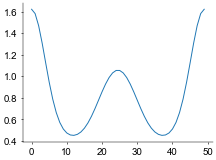

In [130]:
plt.plot(1/tau[:, 0])